# Lab 1 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Linear

### Prof. Eduardo e Prof. Pedro

Data da entrega : 30/03 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks.
- Execute todo notebook e salve tudo em um PDF nomeado como "NomeSobrenome-Lab1.pdf"
- Envie PELO [FORM](https://forms.gle/Taz1wCHtgL2C5MaT8)

# Regressão e Descida do Gradiente

Neste estudo dirigido, resolveremos um problema de regressão, usando algoritmos da descida do gradiente para otimização dos pesos. Vamos implementar a descida do gradiente tradicional e uma versão estocástica com mini-lotes.

Vamos aplicar em um problema de predição de preços de casas (**California Housing Dataset**)

## Bibliotecas e carregando os dados

### Importando as bibliotecas

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

np.random.seed(406177)

A biblioteca [Scikit-learn](https://scikit-learn.org/stable/) é focada em aprendizagem de máquina e fornece diversos métodos de classificação, extração de características, etc. Ela também fornece algumas bases de dados clássicas, por meio de objetos do Pandas.

Se você não conhece o pacote Pandas, veja este [curso rápido](https://www.kaggle.com/learn/pandas).

### Recuperando os dados

In [125]:
housing_data = fetch_california_housing()

In [126]:
Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])

In [127]:
df = Features.join(Target)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## Entendendo e pré-processando os dados (1 ponto)

### Entendendo os dados

Vamos usar apenas uma característica, renda média (MedInc), como variável independente e o preço final como variável dependente.

In [128]:
df[['MedInc', 'Target']].describe()

,MedInc,Target
count,20640.000000,20640.000000
mean,3.870671,2.068558
std,1.899822,1.153956
min,0.499900,0.149990
25%,2.563400,1.196000
50%,3.534800,1.797000
75%,4.743250,2.647250
max,15.000100,5.000010


### Pre-processamento : removendo outlier e ajustando escala

Perceba que em 75% dos dados, a renda média (MedInc) é menor que 5 e que o valor da casa (Target) é menor que 3. Vamos remover rendas maiores que 5 e casas com preço maior que 3, para evitar valores espúrios e outliers.

In [129]:
print(df.shape)
df = df[df.MedInc < 5]
df = df[df.Target < 3]
df

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


**Normalização** - Também vamos deixar as duas variáveis na faixa entre 0 e 1 

In [130]:
def scale(x):
    min = x.min()
    max = x.max()
    return pd.Series([(i - min)/(max - min) for i in x])

X = scale(df.MedInc)
y = scale(df.Target)

In [131]:
#conferindo o valor máximo 
X.max(), y.max(), X.size, type(X)


(1.0, 1.0, 14653, pandas.core.series.Series)

Valor esperado: (1.0, 1.0)

### Plotando os dados

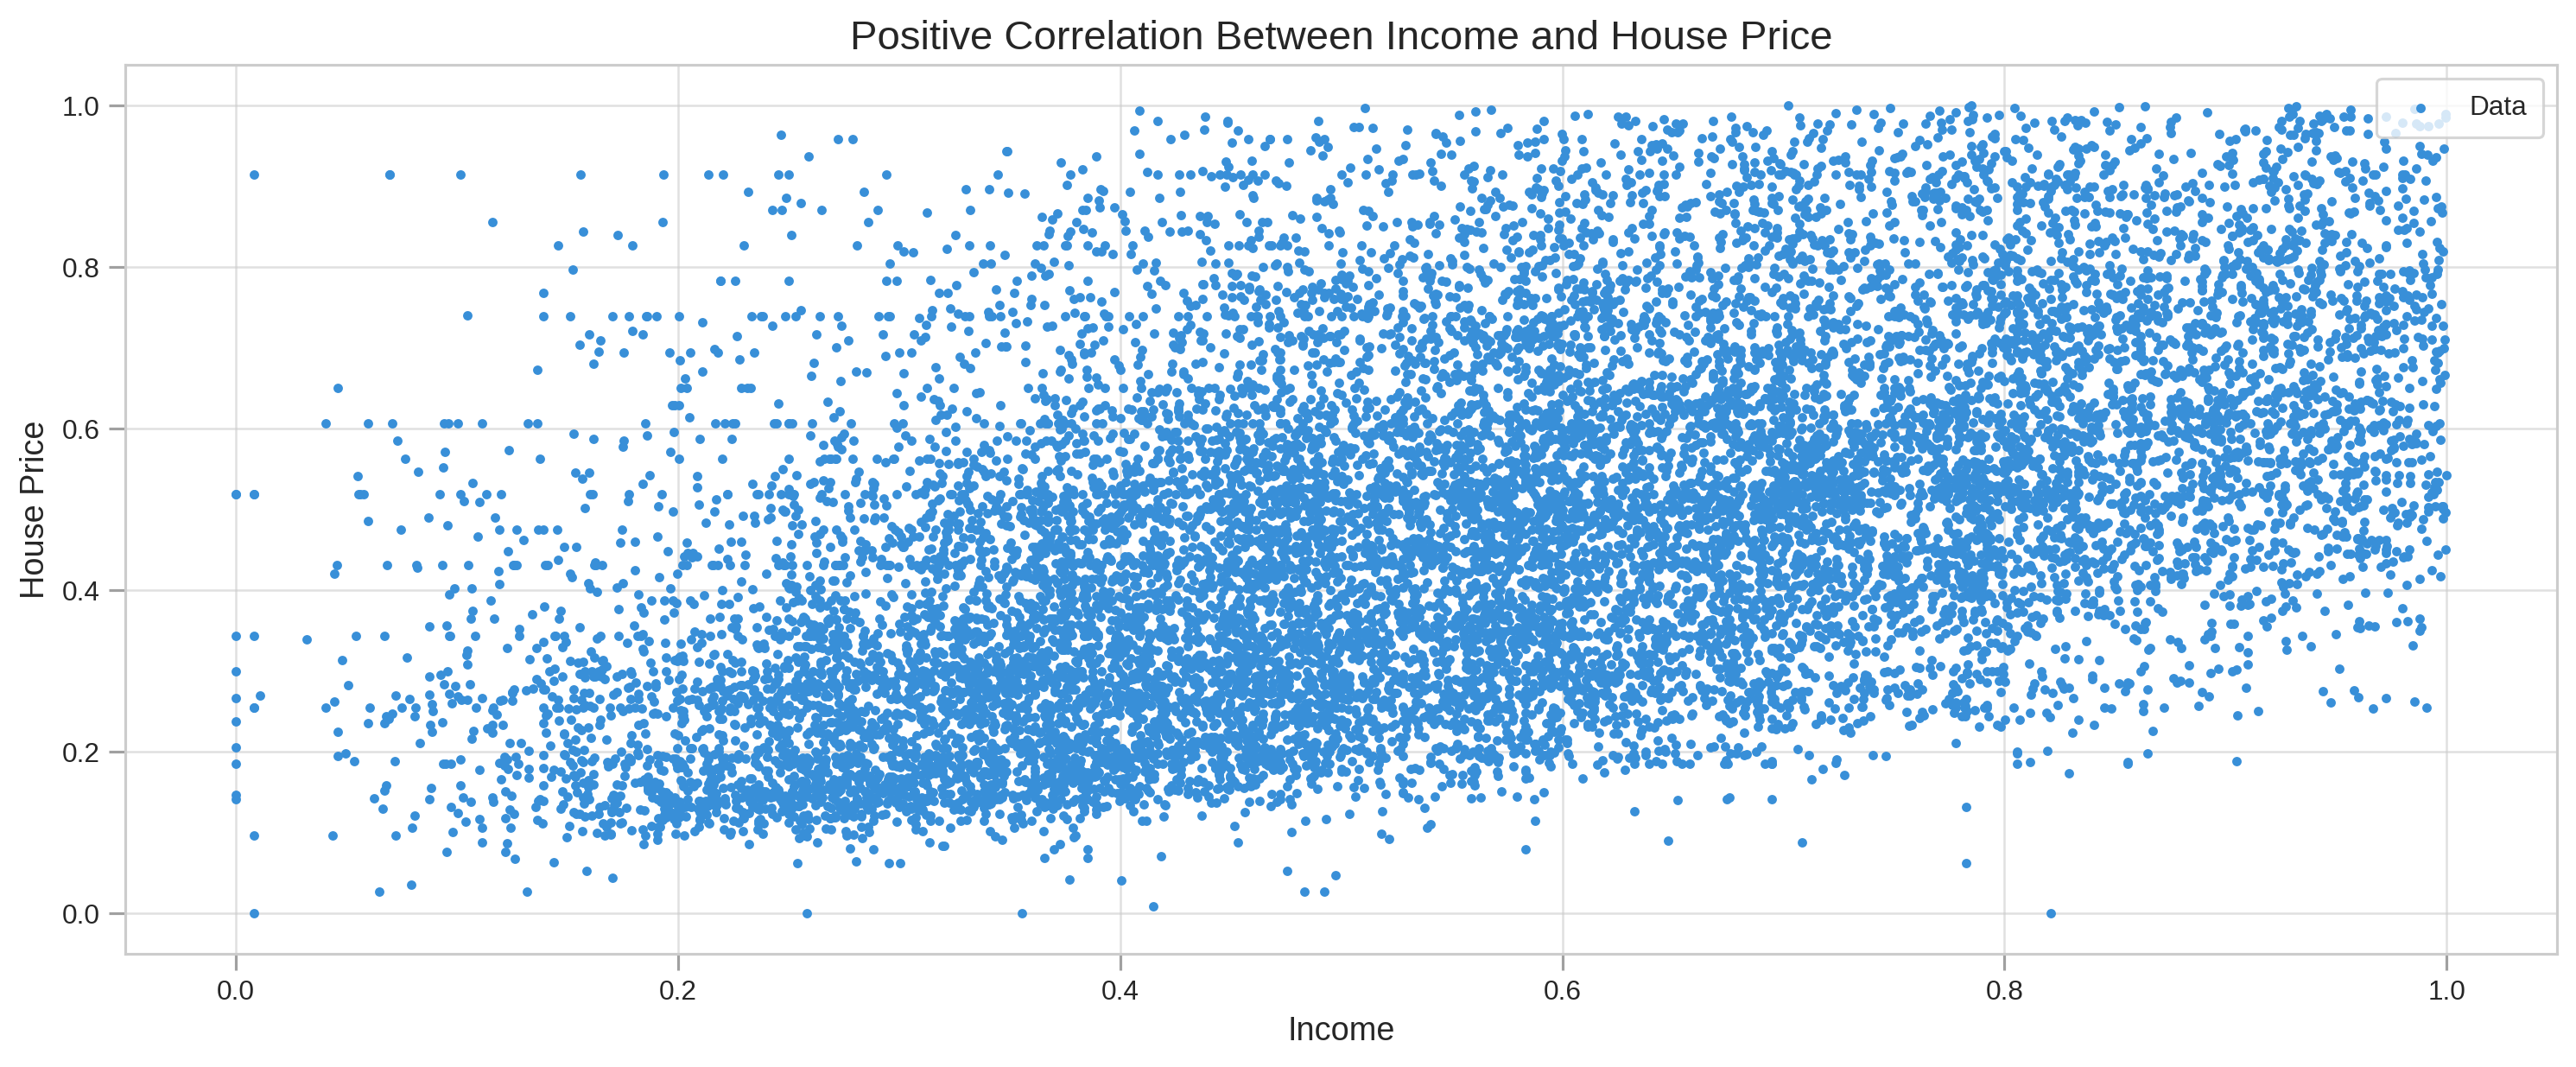

In [132]:
plt.figure(figsize=(16,6))
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.scatter(X, y, label='Data', c='#388fd8', s=6)
plt.title('Positive Correlation Between Income and House Price', fontSize=15)
plt.xlabel('Income', fontSize=12)
plt.ylabel('House Price', fontSize=12)
plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
plt.show()

### [1pt] Discussão : Por que os dados devem ser normalizados entre 0 e 1 ?

**ToDo** : Discorra sobre a questão acima.

Todos os dados usados pelo modelo, tanto de entrada (features) quanto rótulos (para casos de regressão como o exemplo dado) devem ser normalizados, isso é, reposicionados entre 0 e 1 ou deslocados para ter média 0 e variância unitária. Se não forem normalizados, os valores muito grandes ou muito pequenos de variáveis irão influenciar (de forma errada) o modelo nos cáluclos da predição.

## Descida do Gradiente (9 pontos)

### [4pt] Descida do Gradiente

Vamos resolver uma regressão linear, de uma única característica - MedInc -  (vetor de pesos tem uma dimensão), do tipo $Y = mX + b$, e usar erro quadrático médio (mean squared error) como funçào objetivo para a descida do gradiente.

![MSE](https://drive.google.com/uc?export=view&id=1XrK7UrWYdKk2iMgnDPmTMtYbpX44mULB)

considerando y chapéu como saída do nosso modelo e y como o rótulo. Expandindo a função é : 

![exp](https://drive.google.com/uc?export=view&id=1g_xl-nAjSpzBa-ee6k0rLX5xNF6QlQH-)

Derivada em relação a m :

![derm](https://drive.google.com/uc?export=view&id=1UYon6FpnwGD3oLS9-Sx5tOunRBI1dagM)

Derivada em relação a b :

![derb](https://drive.google.com/uc?export=view&id=1ukBveq7BRl7sV2NE__sXnminbpiRrQqd)


#### [4pt] Função da descida do gradiente e para plotar a regressão

Vamos implementar uma função chamada *gradient_descent*, seguindo alguns passos:



1.   Inicializar m e b aleatoriamente (entre 0 e 1)
2.   Iterar por um número de épocas (*epoch*)
3.   A cada iteração, calcular o valor predito, o erro quadrático entre o valor predito e $y$, atualizar os valores de m e b no sentido contrário do gradiente (o ajuste deve ser controlado por um taxa de aprendizado - *Learning Rate (lr)*).
4.   Armazenar m, b e erro corrente para análise futura




In [133]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    
    '''
    Descida do Gradiente
    '''

    m, b = np.random.rand(2) # ToDo : inicialize aleatoriamente entre 0 e 1

    log, mse_log = [], [] # listas para armazenar o processo de aprendizado
    N = len(X) # número de instâncias total do conjunto
    
    for e in range(epoch):
        
        predict = m*X + b # ToDo : propague (feed-forward) ara obter as predições : m*X + b
        MSE = 1/N*sum(((predict - y)**2))  # ToDo : calcule o erro quadrático médio, conforme equação acima
        
        f_dm = 1/N*sum(-2*X*(y - (m*X + b))) # ToDo : compute a derivada: derivada parcial em relação a 'm'
        f_db = 1/N*sum(-2*(y - (m*X + b))) #derivada parcial em relação a 'b'

        # atualize m e b
        m -=  lr*f_dm # ToDo : atualize m com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        b -=  lr*f_db # ToDo : atualize b com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        
        # armazena para uso futuro
        log.append((m, b))
        mse_log.append(MSE)        
    
    return m, b, log, mse_log

In [134]:
def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(16,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.15)
    plt.plot(X, y_pred, c='#ff7702', lw=3, label='Regressao')
    plt.title(title, fontSize=14)
    plt.xlabel('Renda', fontSize=11)
    plt.ylabel('Preço', fontSize=11)
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

#### Teste da função

Use a função gradient_descent, para o conjunto de dados de casas ($X$ e $y$) carregados acima, com uma taxa de aprendizado de 0.01 por 1000 épocas. Analise as curvas plotadas.

MSE: 0.036309263905409506


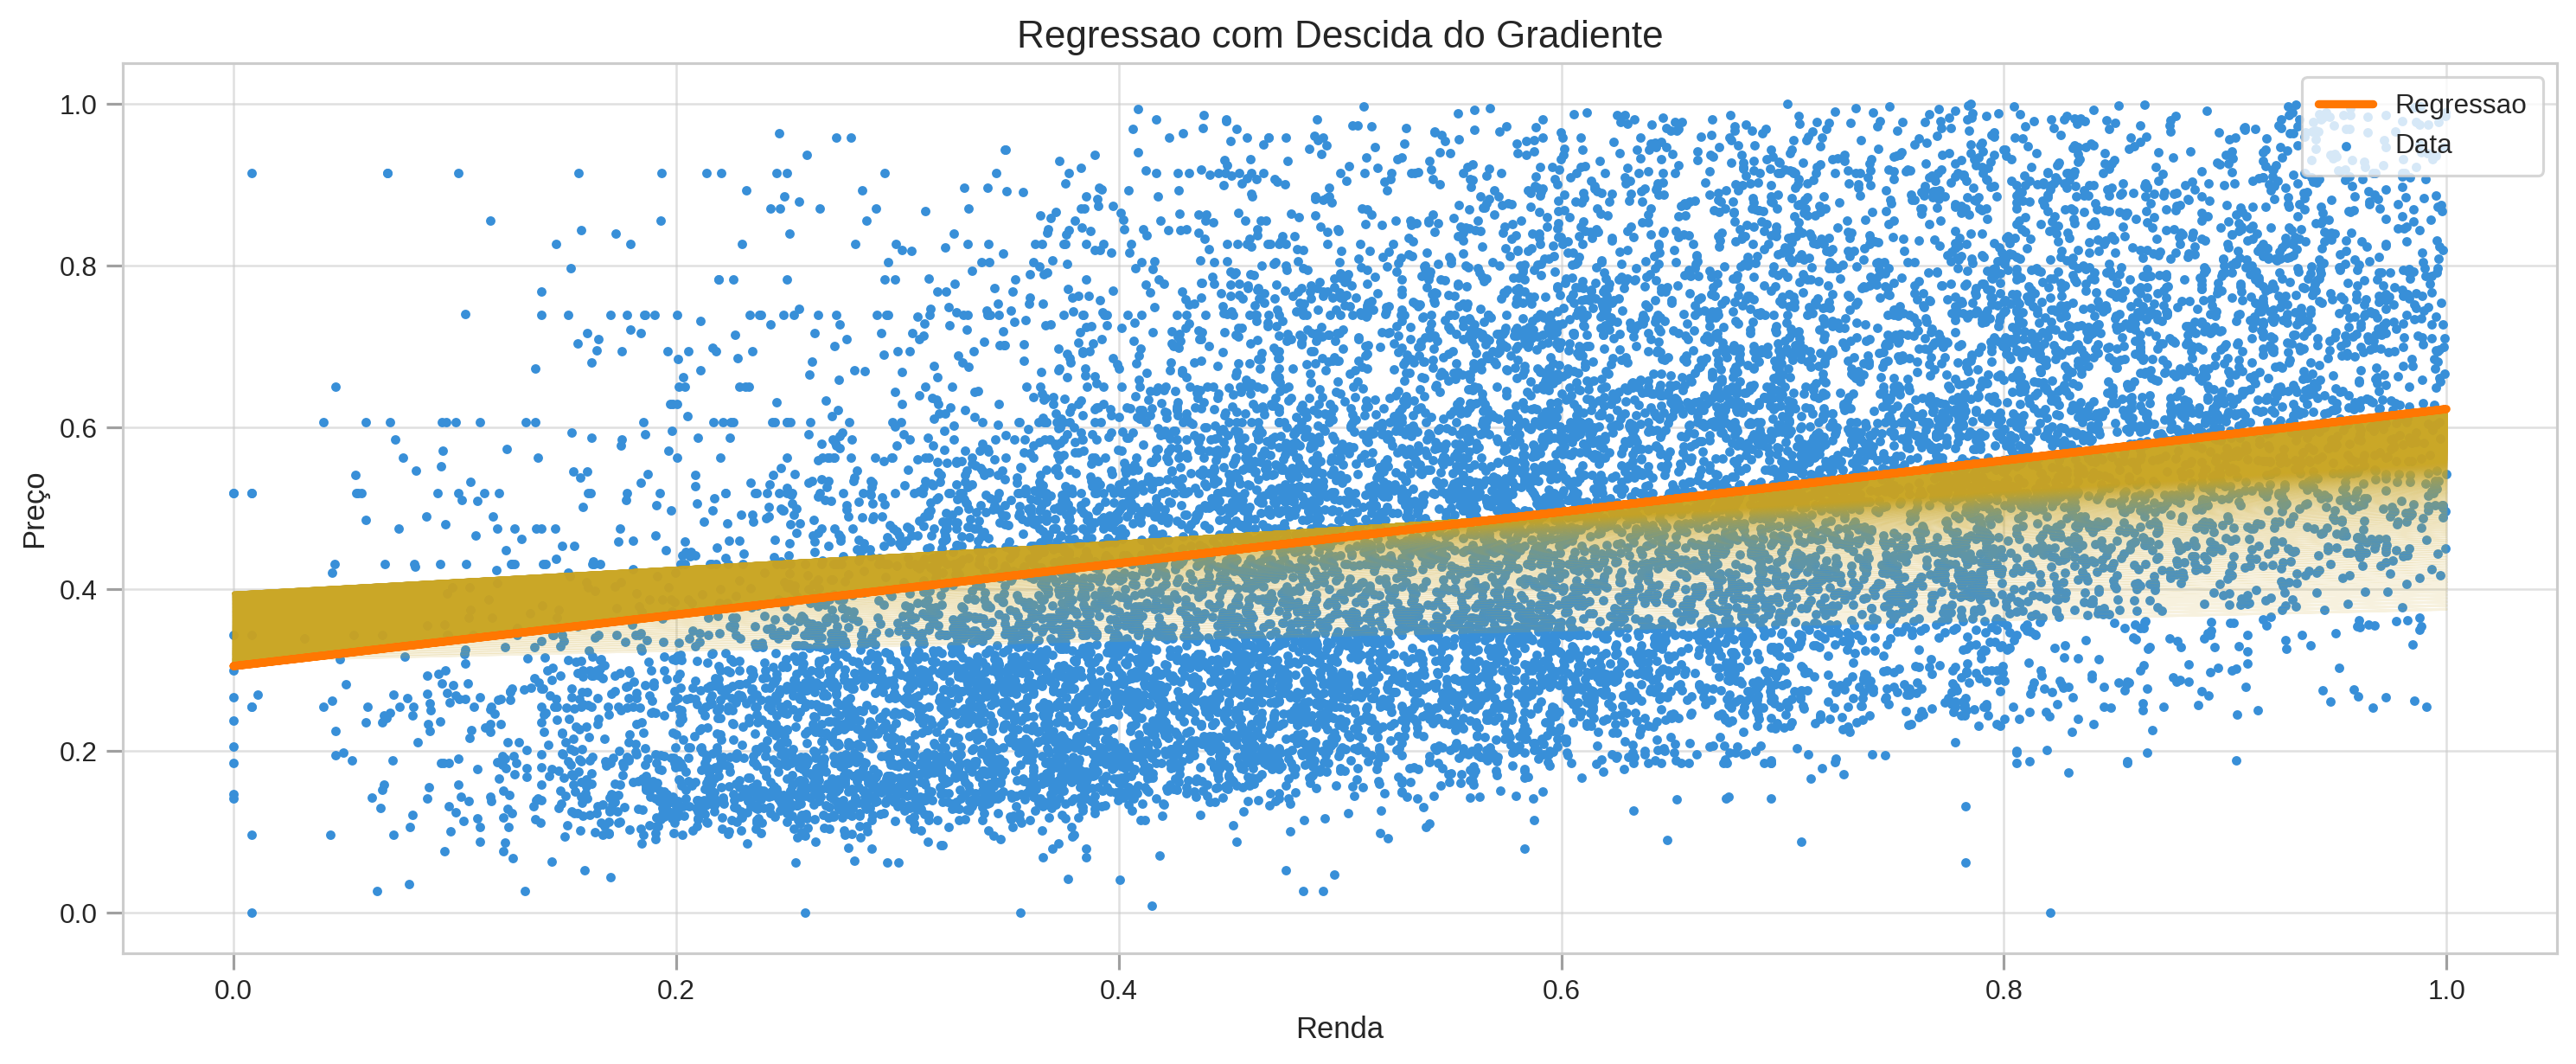

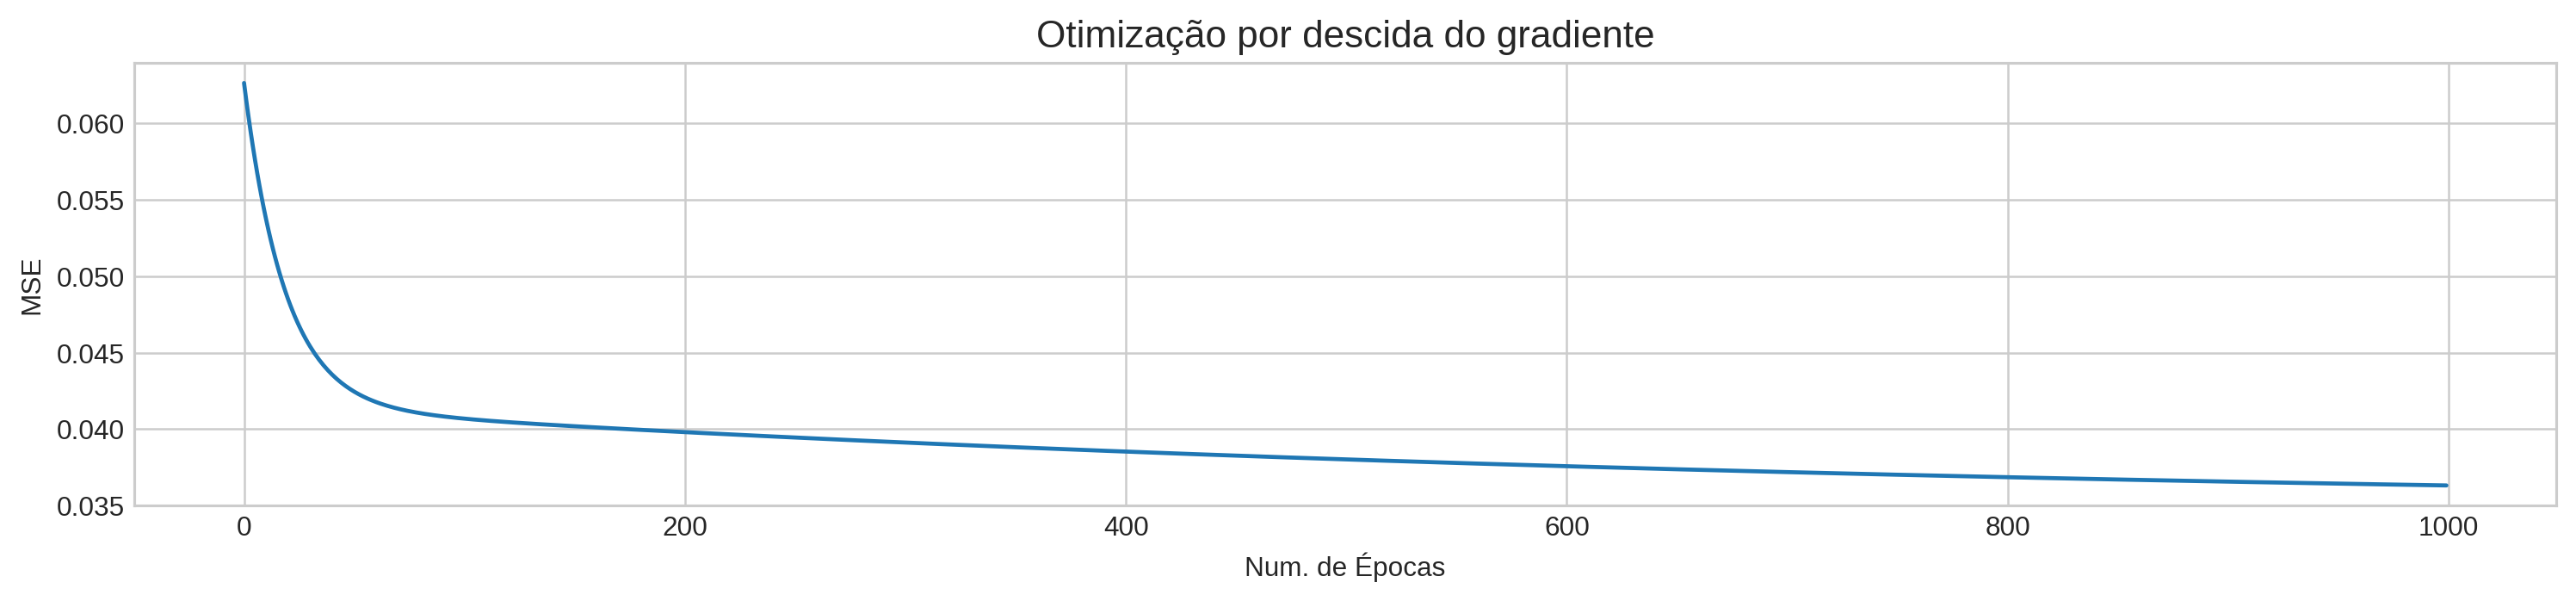

In [135]:
m, b, log1, mse1 = gradient_descent(X, y, lr=0.01, epoch=1000)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log1, title="Regressao com Descida do Gradiente")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse1)), mse1)
plt.title('Otimização por descida do gradiente', fontSize=14)
plt.xlabel('Num. de Épocas')
plt.ylabel('MSE')
plt.show()

Valor esperado:
MSE: 0.034740339862818236

### [4pt] Descida do Gradiente Estocástica

A descida do gradiente estocástica (do inglês Stochastic Gradient Descent - SGD) tem este nome por que ela não é realizada no conjunto de dados inteiro, mas em uma sub-amostragem do conjunto de dados. Esta sub-amostragem é aleatória. Na SGD, o gradiente é aplicado a um sub-conjunto dos dados (um lote ou mini-lote). 

A função deve seguir:

1.   Inicializar m e b aleatoriamente (entre 0 e 1)
2.   Iterar por um número de épocas
3.   A cada iteração, amostrar um mini-lote (sub-conjunto) de $X$ (*batch_size*),  calcular o valor predito para o mini-lote, calcular o erro quadrático para o mini-lote (entre valor predito e $y$), atualizar os valores de m e b, no sentido contrário do gradiente (o ajuste deve ser controlado por um taxa de aprendizado - *lr*).
4.   Armazenar m, b e erro corrente para análise futura

In [142]:
def SGD(X, y, lr=0.05, epoch=10, batch_size=2):
        
    '''
    Descida do Gradiente Estocástica
    '''
    
    #m, b = 0.002, 0.5 # inicializa os parâmatros 
    m, b = np.random.rand(2) # inicializa os parâmatros com valores aleatórios entre 0 e 1
    log, mse_log = [], [] # listas para armazenar o processo de aprendizado
    
    for _ in range(epoch):
        
        # ToDo : amostre aleatoriamnte algumas instâncias (até batch_size)
        # Sorteira aleatóriamento batch_size amostras de X, com igual probabilidade (distribuição uniforme):
        samples = [np.random.randint(0, X.size) for _ in range(batch_size)] 
        mini_batch_X = X[samples] # ToDo : complete
        mini_batch_y = X[samples]  # ToDo : complete
        N = len(mini_batch_X)

        predict = m*mini_batch_X + b # ToDo : propague (feed-forward) ara obter as predições : m* mini_batch_X + b

        MSE = 1/N*sum((predict - mini_batch_y)**2) # ToDo : complete
        
        fMini_dm = 1/N*sum(-2*mini_batch_X*(mini_batch_y - (m*mini_batch_X + b)))  # ToDo : compute a derivada do mini-lote
        fMini_db = 1/N+sum(-2*(mini_batch_y - (mini_batch_X*m + b)))
        # Updating parameters m and b
        m -= lr*fMini_dm # ToDo : atualize m com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        b -= lr*fMini_db # ToDo : atualize b com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)

        log.append((m, b))
        mse_log.append(MSE)      
    
    return m, b, log, mse_log

Use a função SGD, para o conjunto de dados de casas ($X$ e $y$) carregados acima, com uma taxa de aprendizado de 0.01 por 1000 épocas.

MSE: 0.10049939413207475


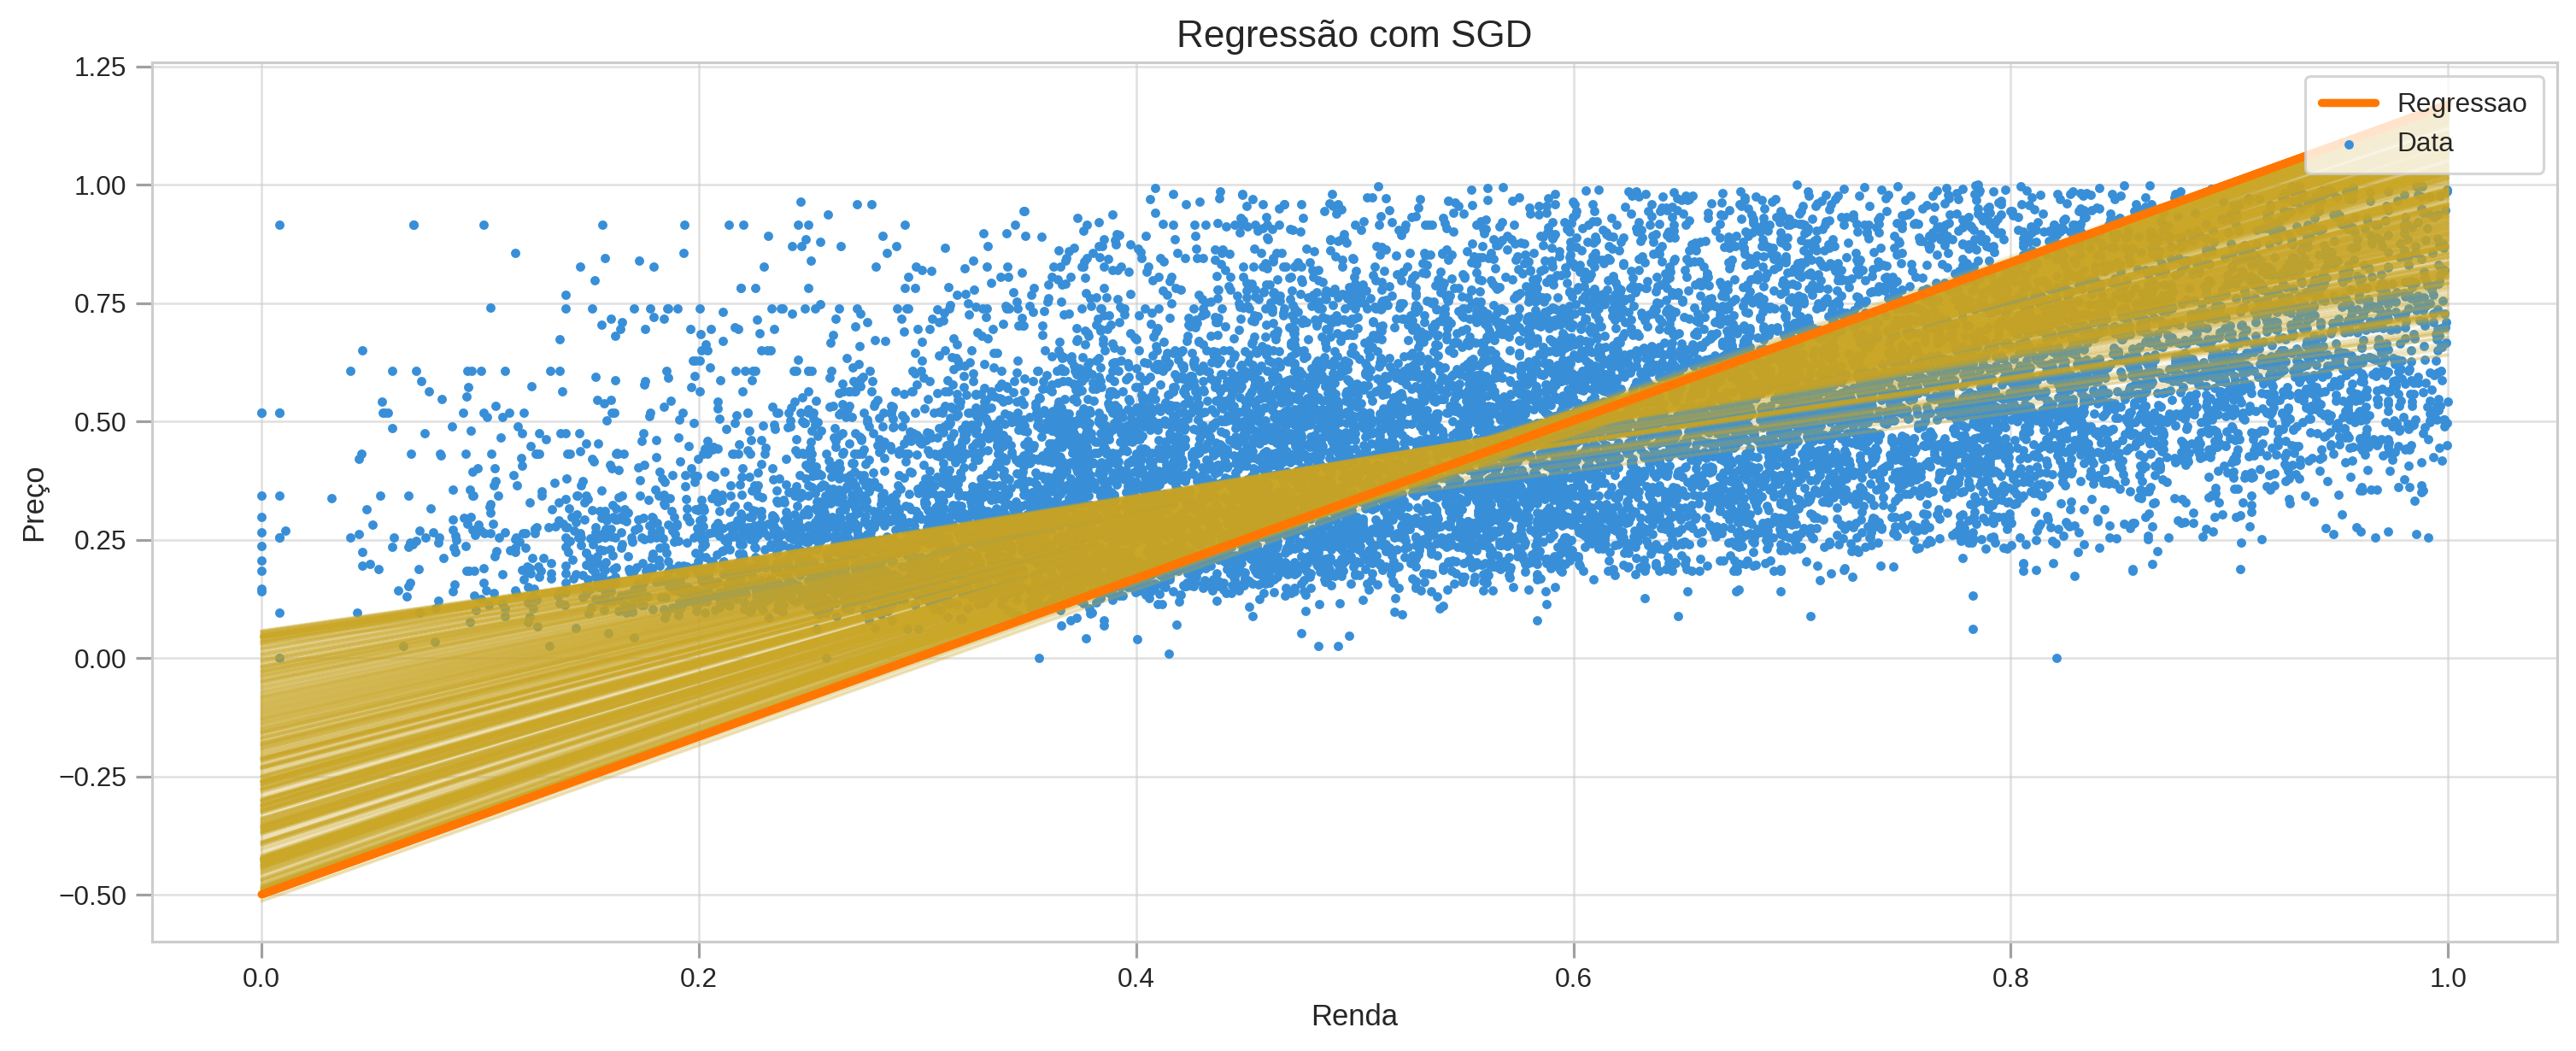

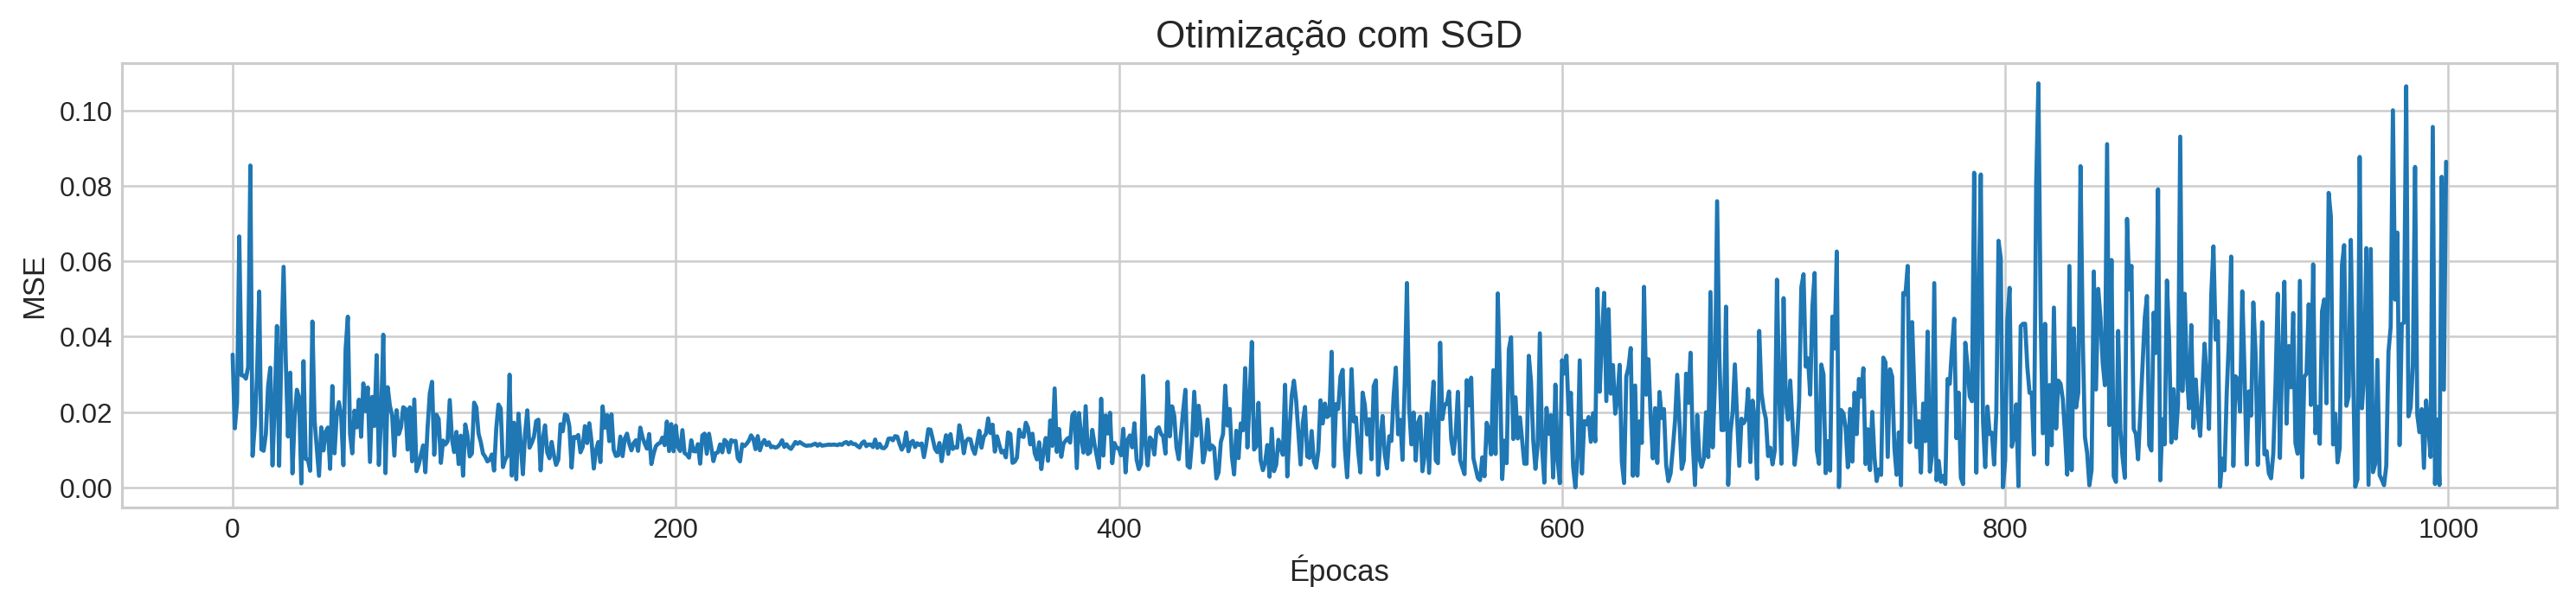

In [143]:
m, b, log2, mse2 = SGD(X, y, lr=0.01, epoch=1000, batch_size=2)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log2, title="Regressão com SGD")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse2)), mse2)
plt.title('Otimização com SGD', fontSize=14)
plt.xlabel('Épocas', fontSize=11)
plt.ylabel('MSE', fontSize=11)
plt.show()

Valor esperado: 
MSE: 0.03760346179860297

### [1pt] Discussão : O que você conclui, olhando para as duas curvas de custo (MSE x Épocas) ?

toDo : Discorra sobre a questão acima

O erro final exibido (MSE: 0.10049939413207475) calculado para os dados usados pelo treinamento com minibatchs usando SGD é bem mais alto que aquele calculado na regressão inicial.
Ao chamar a função SGD considerando um batch_size de 2, serão selecionadas, aleatoriamente (sorteio com reposição!), apenas 2 amostras para avaliação da função de perda (MSE). Nesse caso na melhor das hipóteses, para 1000 épocas, no máximo 2000 amostras distintas do conjunto de dados (de 14653 amostras) seriam selecionadas para 'treinamento'. Esse fato justifica o ajuste ruim da reta de regressão, conforme o gráfico 'Regressão com SGD'. Se considerarmos lotes maiores (ex. 20) o ajuste melhora para em torno de um MSE de 0.5.

Quanto ao gráfico 'Otimização com SGD' ele apenas está exibindo os MSE calculados em cada um dos lotes de 2 amostras, sorteados em cada uma das 1000 épocas. **Obs.: a função SGD pode ser alterada para calcular o MSE do conjunto de dados. Calcular o MSE de cada mini_batch foi apenas uma escolha.**

Assim feito, o último grafico não revela uma curva de aprendizagem para o conjunto de dados. A magnitude do erro irá variar muito a cada vez que 2 amostras (fora da distribuição normal 'esperada' pela regressão) são selecionadas. Lembrando que o sorteio considera uma distribuição uniforme.